# Deep Learning
## HW3 - Problem 2 

1.   Full Name: Radmehr Karimian
2.   Student Number: 98103556

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from PIL import Image
import json
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from collections import defaultdict
import copy
from copy import deepcopy
import pickle

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ResNet50_Weights.IMAGENET1K_V2.transforms())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ResNet50_Weights.IMAGENET1K_V2.transforms())
dataloader = dict()
dataloader['train'] = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataloader['test'] = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [51]:
resnet50_model = resnet50(weights="IMAGENET1K_V2")
paramresnet50 = resnet50_model.parameters()
for param in paramresnet50: 
  param.requires_grad = False
resnet50_model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

cross_entropy_criterion = nn.CrossEntropyLoss()
fc_params = resnet50_model.fc.parameters()
resnet50_optimizer = optim.SGD(fc_params, lr=0.001, momentum=0.9)
resnet50_losses = defaultdict(list)
resnet50_accs = defaultdict(list)


In [5]:
def teapoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    optimizer.zero_grad()

    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)
            p = net(x)
            loss = criterion(p, y)
            epoch_loss += float(loss)
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'epoch -> acc: {100*epoch_true / epoch_all:3.2f}%, loss: {epoch_loss / (i + 1):.6f}')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

In [6]:
def tspoch(net, criterion, dataloader, accs_test ,loss_test ):

    epoch_loss = 0
    true = 0
    true_topfive = 0
    all = 0
    i = 0

    net.eval()

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)
            loss = criterion(p, y)
            epoch_loss += float(loss)

            # predict 
            predictions = p.argmax(-1)
            all += len(predictions)
            true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {true * 100. / all:.2f}% ')

        accs_test.append(float(true / all))
        loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test

In [14]:
accs = []
class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(nn.Linear(2048, 10))
      
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x
weights = ResNet50_Weights.DEFAULT
net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
net.fc = nn.Sequential()
for param in net.parameters():
  param.requires_grad = False
net = lastLayer(net).to(device)

In [18]:
accs_train = []
loss_train = []
accs_test = []
loss_test = []
params_to_update = []
for name,param in net.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
criterion = nn.CrossEntropyLoss().to(device)
fc_params = resnet50_model.fc.parameters()
optimizer = torch.optim.RMSprop(params_to_update, lr=2e-3)
for e in range(10):
     accs_train,loss_train = teapoch(net, criterion, optimizer,  dataloader['train'],accs_train,loss_train)
     accs_test,loss_test = tspoch(net, criterion, dataloader['test'],accs_test,loss_test)
     if accs_test[-1]==max(accs_test):
        torch.save(net.state_dict(), 'Resnet50_Cifar10.pth')

Loss: 6.890e-01 - Acc: 78.93% : 100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


In [14]:
def plot_history(accs_train, accs_test, loss_train , loss_test):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(accs_train)
    plt.plot(accs_test)
    plt.legend(['train acc', 'test acc'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.subplot(2, 1, 2)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.legend(['train loss', 'test loss'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

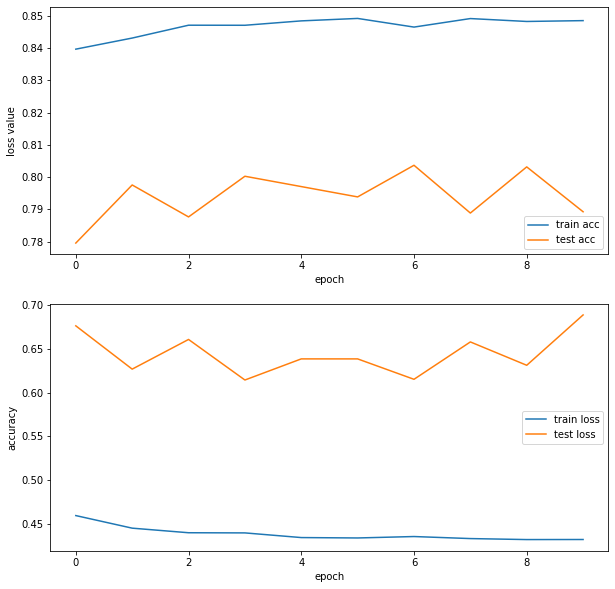

In [20]:
plot_history(accs_train, accs_test, loss_train , loss_test)

In [21]:
def train_teacher(alpha,taw,student,teacher, criterion, optimizer, dataloader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    student.train()
    optimizer.zero_grad()
    m = nn.Softmax(dim=1)
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)

            prediction_student = student(x)
            prediction_teacher = teacher(x)

            soft_student_1 = m(prediction_student) 
            soft_student_t = m(prediction_student.divide(taw)) 
            soft_teacher = m(prediction_teacher.divide(taw)) 

            loss1 = criterion(soft_student_1, y)
            loss2 = criterion(soft_student_t, soft_teacher)

            loss = loss1.multiply(1-alpha)+loss2.multiply(alpha)

            epoch_loss += float(loss)
            predictions = prediction_student.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'train -> acc: {100*epoch_true / epoch_all:3.2f}%, loss: {epoch_loss / (i + 1):.6f}')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

In [22]:
def test_teacher(alpha,taw,student,teacher, criterion, dataloader,  accs_test ,loss_test ):

    epoch_loss = 0
    epoch_true = 0
    epoch_true_topfive = 0
    epoch_all = 0
    i = 0
    m = nn.Softmax(dim=1)
    student.eval()

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)

            prediction_student = student(x)
            prediction_teacher = teacher(x)

            soft_student_1 = m(prediction_student) 
            soft_student_t = m(prediction_student.divide(taw)) 
            soft_teacher = m(prediction_teacher.divide(taw)) 

            loss1 = criterion(soft_student_1, y)
            loss2 = criterion(soft_student_t, soft_teacher)

            loss = loss1.multiply(1-alpha)+loss2.multiply(alpha)

            epoch_loss += float(loss)

            predictions = soft_student_1.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'test ->  Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}% ')

        accs_test.append(float(epoch_true / epoch_all))
        loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test

In [23]:
class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(2048, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

teacher = resnet50()
teacher.fc = nn.Sequential()
teacher = lastLayer(teacher).to(device)
teacher.load_state_dict(torch.load("Resnet50_Cifar10.pth"),strict = False)
teacher.eval()

lastLayer(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [24]:
class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Linear(512, 10))
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

student = resnet18()
student.fc = nn.Sequential()
student = lastLayer(student).to(device)

In [25]:
criterion = nn.CrossEntropyLoss().to(device)
params_to_update = []
for name,param in student.named_parameters():
  if param.requires_grad == True:
      params_to_update.append(param)

In [29]:
optimizer = torch.optim.RMSprop(params_to_update, lr=1e-4)
alpha = 0.5
taw  = 2
epochs = 1
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
  accs_train,loss_train = train_teacher(alpha,taw,student,teacher, criterion, optimizer,dataloader['train'],accs_train,loss_train)
  accs_test,loss_test = test_teacher(alpha,taw,student,teacher, criterion, dataloader['test'],accs_test,loss_test)
  if accs_test[-1]==max(accs_test):
    torch.save(student.state_dict(), 'Resnet18_Cifar10_KD.pth')

test ->  Loss: 1.886e+00 - Acc: 63.38% : 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]


In [30]:
alpha = 0.3
taw  = 2
epochs = 1
accs_train_2 = []
loss_train_2 = []
accs_test_2= []
loss_test_2 = []
for e in range(epochs):
  accs_train_2,loss_train_2 = train_teacher(alpha,taw,student,teacher, criterion, optimizer,dataloader['train'],accs_train,loss_train)
  accs_test_2,loss_test_2 = test_teacher(alpha,taw,student,teacher, criterion, dataloader['test'],accs_test,loss_test)
  if accs_test[-1]==max(accs_test):
    torch.save(student.state_dict(), 'Resnet18_Cifar10_KD2.pth')

test ->  Loss: 1.819e+00 - Acc: 68.54% : 100%|██████████| 157/157 [00:40<00:00,  3.87it/s]


In [31]:
def train_wo_teacher(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    optimizer.zero_grad()
    m = nn.Softmax(dim=1)
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 
            x = x.to(device)  
            y = y.to(device)
            p = m(net(x))
            loss = criterion(p, y)
            epoch_loss += float(loss)
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            pbar.set_description(f'epoch -> acc: {100*epoch_true / epoch_all:3.2f}%, loss: {epoch_loss / (i + 1):.6f}')
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

In [32]:
class lastLayer(nn.Module):
  def __init__(self, pretrained):
    super(lastLayer, self).__init__()
    self.pretrained = pretrained
    self.last = nn.Sequential(nn.Linear(2048, 10))
      
  def forward(self, x):
    x = self.pretrained(x)
    x = self.last(x)
    return x

teacher = resnet50()
teacher.fc = nn.Sequential()
teacher = lastLayer(teacher).to(device)
teacher.load_state_dict(torch.load("Resnet50_Cifar10.pth"),strict = False)
teacher.eval()

lastLayer(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [33]:
class lastLayer(nn.Module):
    def __init__(self, pretrained):
      super(lastLayer, self).__init__()
      self.pretrained = pretrained
      self.last = nn.Sequential(
      nn.Linear(512, 10))

    def forward(self, x):
      x = self.pretrained(x)     
      x = self.last(x)
      return x

student = resnet18()
student.fc = nn.Sequential()
student = lastLayer(student).to(device)

In [34]:
criterion = nn.CrossEntropyLoss().to(device)
params_to_update = []
for name,param in student.named_parameters():
  if param.requires_grad == True:
      params_to_update.append(param)

In [36]:
optimizer = torch.optim.RMSprop(params_to_update, lr=1e-4)
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(3):
  accs_train,loss_train = train_teacher(alpha,taw,student,teacher, criterion, optimizer,dataloader['train'],accs_train,loss_train)
  accs_test,loss_test = test_teacher(alpha,taw,student,teacher, criterion, dataloader['test'],accs_test,loss_test)
  if accs_test[-1]==max(accs_test):
    torch.save(student.state_dict(), 'Resnet18_Cifar10_WO_teacher.pth')

test ->  Loss: 1.937e+00 - Acc: 55.20% : 100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


 The performance of training using the teacher model is better because it gives the student model a hint about how a good distribution on the probability of the output vector is. In the classic method we only push the output vector to have the highest probability on the correct class.

In [64]:
from torchvision.models import resnet50, ResNet50_Weights
resnet50_model = resnet50(weights="IMAGENET1K_V2")
resnet50_model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
params = resnet50_model.parameters()
for param in params: 
  param.requires_grad = True
criterion = nn.CrossEntropyLoss()
params = resnet50_model.parameters()
resnet50_optimizer = optim.SGD(params, lr=0.001, momentum=0.9)


In [66]:
torch.cuda.empty_cache()

In [11]:
class lastLayer(nn.Module):
  def __init__(self, pretrained):
    super(lastLayer, self).__init__()
    self.pretrained = pretrained
    self.last = nn.Sequential(nn.Linear(2048, 10))
  def forward(self, x):
    x = self.pretrained(x)
    x = self.last(x)   
    return x


from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
net.fc = nn.Sequential()
net = lastLayer(net).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=2e-4)
epochs = 2
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
  print (e)
  accs_train,loss_train = teapoch(net, criterion, optimizer, dataloader['train'],accs_train,loss_train)
  accs_test,loss_test = tspoch(net, criterion, dataloader['test'],accs_test,loss_test)
  if accs_test[-1]==max(accs_test):
    torch.save(net.state_dict(), 'Resnet50_Cifar10_final.pth')

0


Loss: 1.953e-01 - Acc: 93.22% : 100%|██████████| 157/157 [00:33<00:00,  4.63it/s]


1


Loss: 2.625e-01 - Acc: 91.59% : 100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


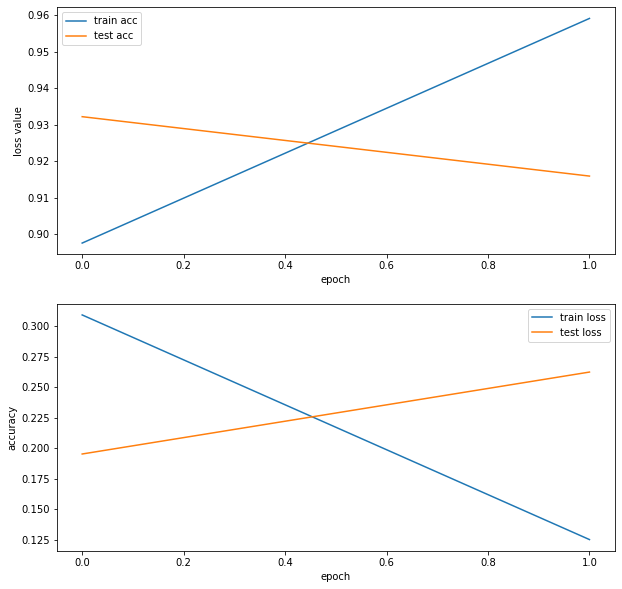

In [15]:
plot_history(accs_train, accs_test, loss_train , loss_test)

It takes longer to train Resnet50 from scratch on Cifar10 (since we are optimizing more parameters), but we will get a higher accuracy on test data only we have a more flexible model to train for this dataset.